In [1]:
import numpy as np
from enum import IntEnum
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
class Bid(IntEnum):
    LOWER = -1
    EQUAL = 0
    HIGHER = 1

In [3]:
c = np.arange(52) % 13 + 2
c

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,  2,  3,  4,  5,
        6,  7,  8,  9, 10, 11, 12, 13, 14,  2,  3,  4,  5,  6,  7,  8,  9,
       10, 11, 12, 13, 14,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,
       14])

In [4]:
def shuffle(cards):
    return np.random.permutation(cards)

cards = shuffle(c)

In [24]:
def simple_play(number, *_):
    # 2 3 4 5 6 7
    # 8
    # 9 10 11 12 13 14
    if number > 8:
        return Bid.LOWER
    else:
        return Bid.HIGHER

simple_play(10)

<Bid.LOWER: -1>

In [31]:
def advanced_play(number, deck):
    if number == 0:
        return Bid.HIGHER
    equal = np.sum(deck == number)
    lower = np.sum(deck < number)
    higher = np.sum(deck > number)

    if equal > lower and equal > higher:
        return Bid.EQUAL
    elif higher > lower:
        return Bid.HIGHER
    else:
        return Bid.LOWER
    # choices = [Bid.EQUAL if card == number else Bid.HIGHER if card > number else Bid.LOWER for card in deck]


In [37]:
advanced_play(0, cards), advanced_play(7, cards), advanced_play(8, cards), advanced_play(14, cards), advanced_play(7, np.array([7]))

(<Bid.HIGHER: 1>,
 <Bid.HIGHER: 1>,
 <Bid.LOWER: -1>,
 <Bid.LOWER: -1>,
 <Bid.EQUAL: 0>)

In [6]:
def draw(cards):
    if len(cards) == 0:
        return 0, []
    else:
        return cards[0], cards[1:] 

In [38]:
def drive(cards, n_closed = 7, retank = False, double_rule = False, play_algo = simple_play):
     table = np.zeros(n_closed)
     sips = []
     index = 0
     cards = cards.copy()
     copy_cards = set(cards.copy())

     while index < n_closed:
          card = table[index]
          play = play_algo(card, cards)
          if card == 0:
              card, cards = draw(cards)
          compare, cards = draw(cards)
          table[index] = compare        
          diff = compare - card
          if diff == play:
               index += 1
          elif diff * play > 0:
               index += 1
          else:
               mult = 2 if (diff == 0 and double_rule) else 1
               sips.append((index + 1) * mult)
               index = 0      
          if len(cards) == 0:
               if retank:
                    cards = shuffle(list(copy_cards - set(table)))
               else: 
                    break

     if len(sips) == 0:
          return [0]
     return sips.copy()


In [26]:
drive(shuffle(c), 10, True)
# a = 0
# for _ in range(10_000):
#     res = drive(shuffle(c), 10, True, True)
#     if res[0] == 0:
#         a += 1
# print(a)

[3,
 4,
 1,
 6,
 7,
 3,
 1,
 7,
 8,
 1,
 5,
 1,
 2,
 4,
 5,
 7,
 3,
 1,
 2,
 2,
 1,
 1,
 5,
 4,
 6,
 2,
 3,
 4,
 3,
 1,
 10,
 1,
 1,
 5,
 1,
 6,
 10,
 2,
 2,
 1,
 4,
 3,
 1,
 8,
 1,
 3,
 3,
 4,
 1,
 2,
 2,
 6,
 2,
 5,
 7,
 10,
 2,
 4,
 3,
 2,
 1,
 5,
 3,
 5,
 3,
 2,
 4,
 7,
 1,
 4,
 2,
 3,
 2,
 5,
 3,
 8,
 4,
 1,
 1,
 5,
 2,
 1,
 3,
 9,
 1]

In [39]:
configs = {}
for i in range(3, 11):
    sip_list = []
    for _ in range(10_000):
        res = drive(shuffle(c), i, True, True, play_algo=advanced_play)
        sip_list.append(res)
    configs[i] = sip_list
for key, value in configs.items():
    configs[key] =  pd.DataFrame(value).stack()

In [40]:
df = pd.concat(configs).reset_index()
df = df.rename(columns={0:'sips', "level_0": "cards", "level_1": "run", "level_2": "try"})
df

,cards,run,try,sips
0,3,0,0,1.0
1,3,0,1,2.0
2,3,0,2,3.0
3,3,0,3,1.0
4,3,0,4,2.0
...,...,...,...,...
918389,10,9999,29,6.0
918390,10,9999,30,2.0
918391,10,9999,31,1.0
918392,10,9999,32,5.0


(0, 10)

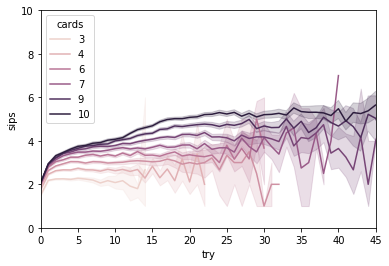

In [42]:
sns.lineplot(data=df, x="try", y ="sips", hue="cards")
plt.xlim(0, 45)
plt.ylim(0, 10)


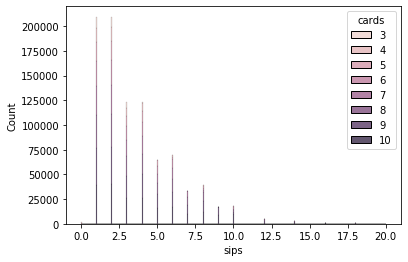

In [43]:
sns.histplot(df, x="sips", hue="cards", multiple="stack")

In [44]:
total = df.groupby(["cards", "run"])["sips"].sum().reset_index()
total

,cards,run,sips
0,3,0,11.0
1,3,1,1.0
2,3,2,0.0
3,3,3,0.0
4,3,4,0.0
...,...,...,...
79995,10,9995,95.0
79996,10,9996,138.0
79997,10,9997,79.0
79998,10,9998,170.0


(0, 100)

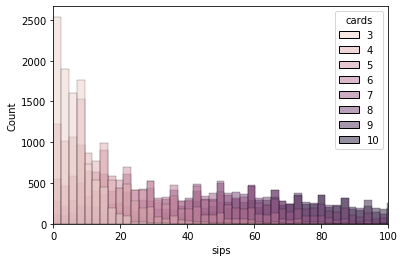

In [45]:
sns.histplot(total, x="sips", hue="cards")
plt.xlim(0, 100)

In [46]:
quants = total.groupby(["cards"])["sips"].quantile([0.01, 0.10, 0.25, 0.5, 0.75, 0.9, 0.99]).unstack()
quants

,0.01,0.10,0.25,0.50,0.75,0.90,0.99
cards,,,,,,,
3,0.0,0.0,2.0,5.0,9.0,13.0,22.0
4,0.0,2.0,5.0,10.0,17.0,24.0,40.0
5,0.0,4.0,9.0,17.0,28.0,40.0,59.0
6,1.0,8.0,16.0,28.0,44.0,55.0,75.0
7,2.0,13.0,25.0,42.0,57.0,69.0,95.0
8,4.0,21.0,38.0,54.0,70.0,87.0,124.0
9,8.0,32.0,50.0,68.0,88.0,111.0,158.0
10,12.0,44.0,61.0,83.0,110.0,138.0,197.0


In [54]:
# total["beers"] = total["sips"] / 25
quants2 = total.groupby(["cards"])["sips"].quantile([0.05, 0.5, 0.95]).unstack()
quants2

,0.05,0.50,0.95
cards,,,
3,0.0,5.0,16.0
4,1.0,10.0,29.0
5,2.0,17.0,47.0
6,4.0,28.0,62.0
7,8.0,42.0,78.0
8,14.0,54.0,98.0
9,21.0,68.0,126.0
10,32.0,83.0,158.0


[Text(33.0, 0.5, 'Number of closed cards'),
 Text(0.5, 15.0, 'Quantile'),
 Text(0.5, 1, 'How many sips do you need to drink while bussing?')]

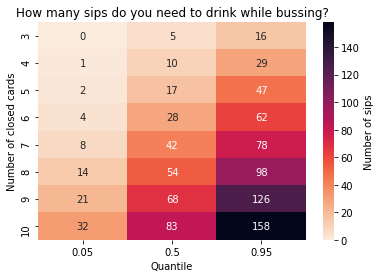

In [58]:
ax = sns.heatmap(quants2, cmap="rocket_r", annot=True, fmt="g")
ax.collections[0].colorbar.set_label("Number of sips")
ax.set(xlabel="Quantile", ylabel="Number of closed cards", title="How many sips do you need to drink while bussing?")
# plt.legend(title="Number of beers")
# plt.yticks([0,1,2,3,4,5,6,7,8,9,10])

In [49]:
total_sips = np.array([sum(l) for l in sip_list])
# np.mean(total_sips), np.std(total_sips)
np.median(total_sips)

83.0

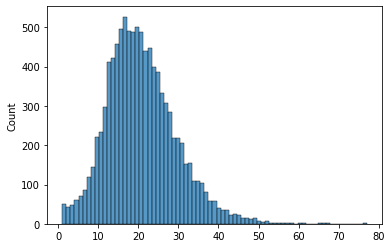

In [50]:
trie_list = np.array([len(sips) for sips in sip_list])
np.mean(trie_list), np.std(trie_list), sum(trie_list == 0), len(trie_list)

sns.histplot(trie_list)